<a href="https://colab.research.google.com/github/nahumsa/Entanglement-VAE/blob/master/VAE%20Entanglement%20Witness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating entangled and separable states with qutip

## Installing dependencies

In [1]:
!git clone https://github.com/nahumsa/Entanglement-VAE.git

Cloning into 'Entanglement-VAE'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 128 (delta 55), reused 20 (delta 6), pack-reused 0
Receiving objects: 100% (128/128), 10.09 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 14.6MB 291kB/s 


In [4]:
% cd Entanglement-VAE/

/content/Entanglement-VAE


## Creating the dataset

We want to take the partial transpose of the density matrix and check if it $\rho > 0$. [link](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion)

Here we are following the Perez-Horondecki criterion, if the partial transpose of the density matrix is negative, the state has to be entangled. 

Because it the state is separable, it will be positive definite by definition.

In [6]:
try:
  %tensorflow_version 1.x

except Exception:
  pass
  
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import os
import seaborn as sns

# Set Random Seed for reproduction
# tf.random.set_seed(1234)

# Changing the figure style
sns.set_context("paper")

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

Checking the distribution of the labels.

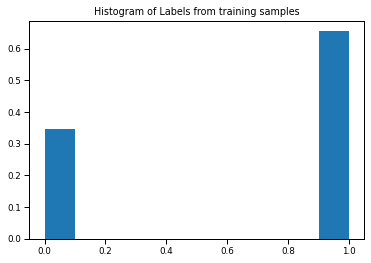

In [9]:
weights = np.ones_like(labels_train)/float(len(labels_train))
plt.hist(labels_train, weights=weights)
plt.title('Histogram of Labels from training samples')
plt.show()

There are more entangled states than separable states as expected.





#Variational Autoencoder for all measurements

In [10]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)
X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y:(5000, 2)


In [11]:
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [16]:
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = False
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [57]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

Train on 5000 samples, validate on 3000 samples
Epoch 1/100
 - 1s - loss: 318.4528 - accuracy: 0.6608 - vae_r_loss: 316.2744 - vae_kl_loss: 2.1784 - val_loss: 318.7863 - val_accuracy: 0.6573 - val_vae_r_loss: 316.1441 - val_vae_kl_loss: 2.6423
Epoch 2/100
 - 1s - loss: 313.9503 - accuracy: 0.6638 - vae_r_loss: 310.1421 - vae_kl_loss: 3.8082 - val_loss: 312.1066 - val_accuracy: 0.6677 - val_vae_r_loss: 309.2870 - val_vae_kl_loss: 2.8195
Epoch 3/100
 - 1s - loss: 311.1595 - accuracy: 0.6616 - vae_r_loss: 308.4267 - vae_kl_loss: 2.7328 - val_loss: 306.5758 - val_accuracy: 0.6633 - val_vae_r_loss: 304.0285 - val_vae_kl_loss: 2.5473
Epoch 4/100
 - 1s - loss: 308.0574 - accuracy: 0.6572 - vae_r_loss: 305.2482 - vae_kl_loss: 2.8092 - val_loss: 306.8204 - val_accuracy: 0.6717 - val_vae_r_loss: 304.2095 - val_vae_kl_loss: 2.6109
Epoch 5/100
 - 1s - loss: 309.9693 - accuracy: 0.6652 - vae_r_loss: 307.4878 - vae_kl_loss: 2.4815 - val_loss: 304.1846 - val_accuracy: 0.6707 - val_vae_r_loss: 302.264

Beta: 1 Accuracy: 0.6773333549499512


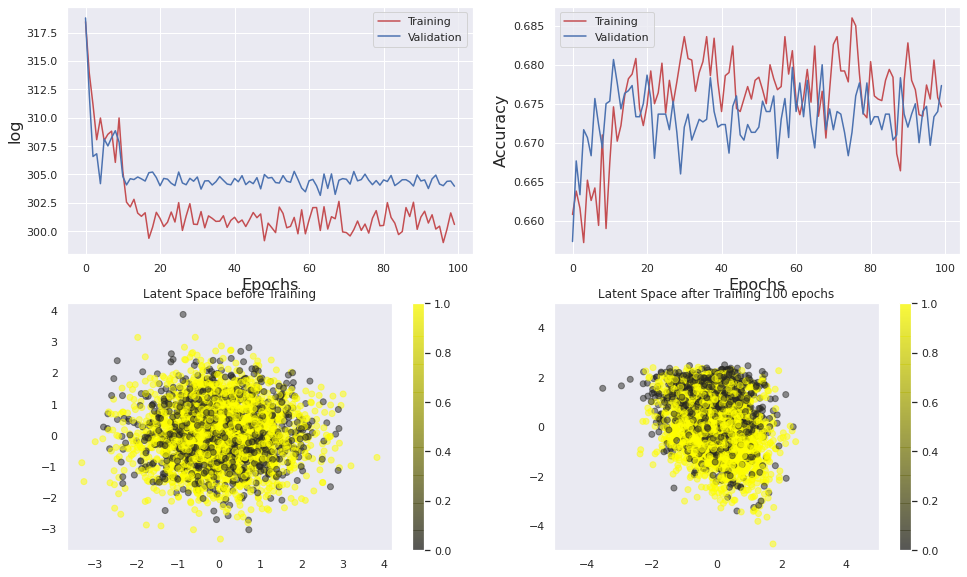

In [58]:
pal = sns.dark_palette("yellow", as_cmap=True)

#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f'Beta: {BETA} Accuracy: {val_accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)


fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])



ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_0 = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu_0[:, 0], z_mu_0[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()

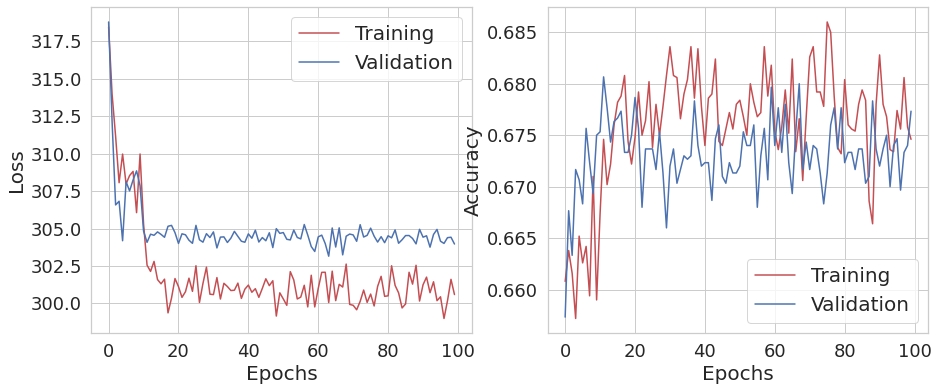

In [59]:
plt.rc('legend',fontsize=20) # using a size in points
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=20)
ax1.set_ylabel('Loss', size=20)
#ax1.set_yscale('log')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=20)
ax2.set_ylabel('Accuracy', size=20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
ax2.legend()

plt.show()

### Using latent space to categorize entanglement

In [ ]:
labels_pred = np.zeros(len(labels_test), dtype=int)
for i,latent in enumerate(z_mu_0):
  if latent[0] < 0:
    labels_pred[i] = 1
  
print('Accuracy choosing > 0 on latent: {}'.format(np.sum(Y_test == labels_pred)/len(Y_test)))

Accuracy choosing > 0 on latent: 0.783


#Variational Autoencoder with limited measurements

## Correlated Measurements

In [30]:
from Utils.Dataset import create_x_correlated

#Transforming in an np.array
X_train = np.array(create_x_correlated(measurements_train))
Y_train = np.array(labels_train)
X_test = np.array(create_x_correlated(measurements_test))
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 9) 
 Y:(5000, 2)


In [31]:
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement_limited'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [32]:
from keras.models import Model
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = False
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [33]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

Train on 5000 samples, validate on 3000 samples
Epoch 1/100
 - 1s - loss: 329.4336 - accuracy: 0.6296 - vae_r_loss: 328.5595 - vae_kl_loss: 0.8741 - val_loss: 280.1924 - val_accuracy: 0.6877 - val_vae_r_loss: 277.3932 - val_vae_kl_loss: 2.7992
Epoch 2/100
 - 1s - loss: 265.6645 - accuracy: 0.7472 - vae_r_loss: 258.4685 - vae_kl_loss: 7.1960 - val_loss: 233.6491 - val_accuracy: 0.7930 - val_vae_r_loss: 227.6585 - val_vae_kl_loss: 5.9906
Epoch 3/100
 - 1s - loss: 239.0355 - accuracy: 0.7778 - vae_r_loss: 233.4480 - vae_kl_loss: 5.5875 - val_loss: 252.3869 - val_accuracy: 0.7437 - val_vae_r_loss: 247.3765 - val_vae_kl_loss: 5.0104
Epoch 4/100
 - 1s - loss: 230.7577 - accuracy: 0.7954 - vae_r_loss: 225.4368 - vae_kl_loss: 5.3209 - val_loss: 232.4378 - val_accuracy: 0.7857 - val_vae_r_loss: 226.7021 - val_vae_kl_loss: 5.7357
Epoch 5/100
 - 1s - loss: 231.7966 - accuracy: 0.7878 - vae_r_loss: 226.3446 - vae_kl_loss: 5.4520 - val_loss: 214.4324 - val_accuracy: 0.8017 - val_vae_r_loss: 209.357

Accuracy: 0.8339999914169312


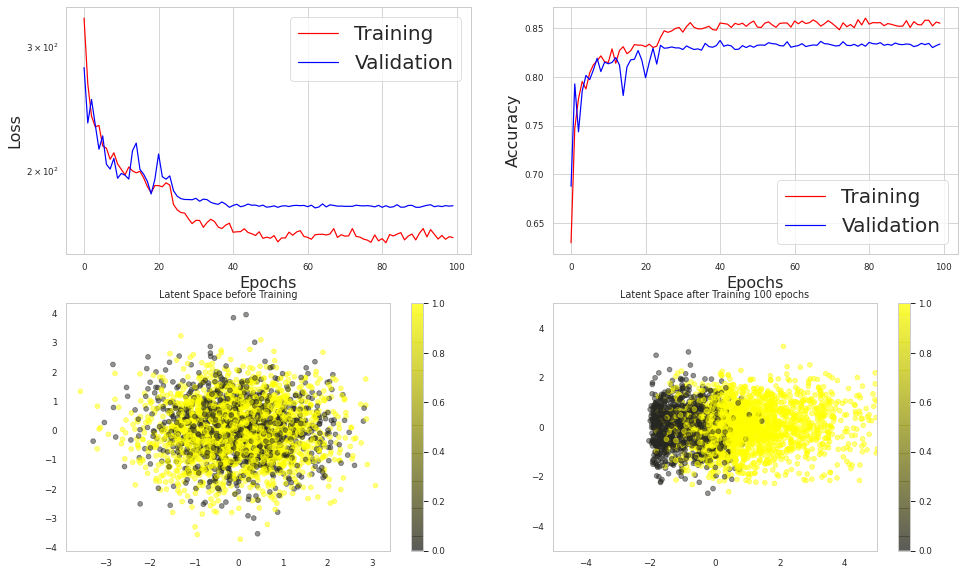

In [34]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f'Accuracy: {val_accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_yscale('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_1 = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu_1[:, 0], z_mu_1[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.grid()
ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)
plt.colorbar(ims, ax=ax4)
plt.show()

In [37]:
labels_pred = np.zeros(len(labels_test), dtype=int)
for i,latent in enumerate(z_mu_1):
  if latent[0] > 0.:
    labels_pred[i] = 1

print('Accuracy choosing >0 on latent: {}'.format(np.sum(Y_test == labels_pred)/len(Y_test)))

Accuracy choosing >0 on latent: 0.8193333333333334


## Uncorrelated Measurements

In [38]:
from Utils.Dataset import create_x_local

#Transforming in an np.array
X_train = np.array(create_x_local(measurements_train))
Y_train = np.array(labels_train)
X_test = np.array(create_x_local(measurements_test))
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 6) 
 Y:(5000, 2)


In [39]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement_limited'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [40]:
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = False
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [ ]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

Accuracy: 0.6800000071525574


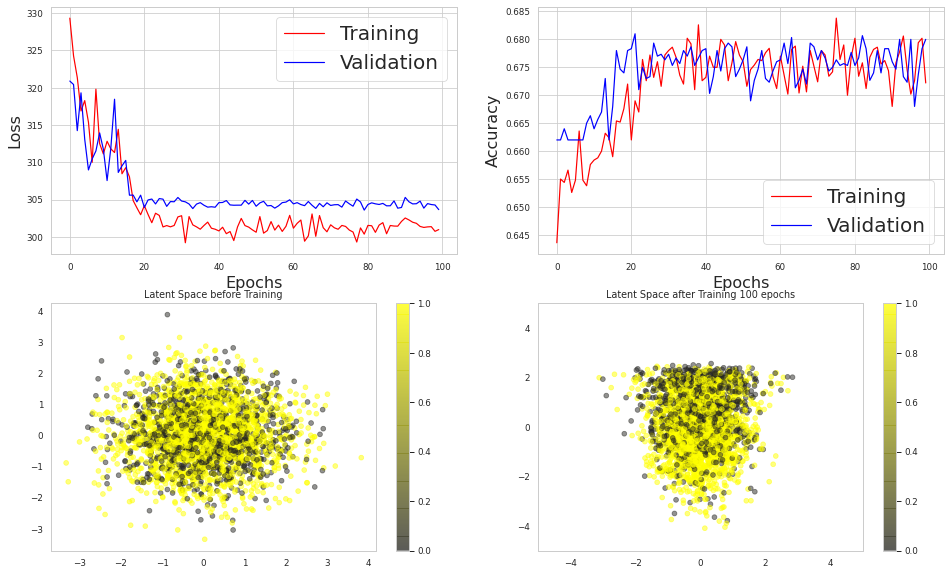

In [42]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f'Accuracy: {val_accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_2 = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu_2[:, 0], z_mu_2[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.grid()
ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)
plt.colorbar(ims, ax=ax4)
plt.show()

In [43]:
labels_pred = np.zeros(len(labels_test), dtype=int)
for i,latent in enumerate(z_mu_2):
  if latent[1] > 0:
    labels_pred[i] = 1

print('Accuracy choosing >0 on latent: {}'.format(np.sum(Y_test == labels_pred)/len(Y_test)))

Accuracy choosing >0 on latent: 0.397


# Other Plots

## Varying $\beta$

This is done running each time for a different $\beta$.

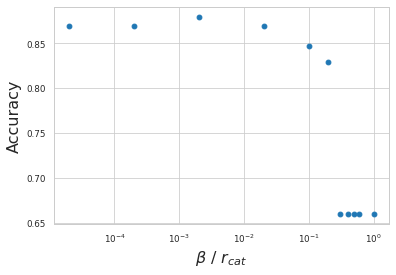

In [28]:
sns.set_style("whitegrid")
beta = [0.01, 0.1, 1, 10, 50, 100, 150, 200, 250, 300, 500]
beta = np.array(beta)/np.max(beta)
acc = [0.87, 0.87, 0.88, 0.87, 0.847, 0.829, 0.66, 0.66, 0.66, 0.66, 0.66]
plt.plot(beta, acc, 'o');
plt.xlabel(r'$\beta$ / $r_{cat}$', size=16)
plt.xscale('log')
plt.ylabel('Accuracy', size=16)
#plt.title(r'Varying $\beta / r_{cat}$')
plt.show()

## Latent Space for all datasets

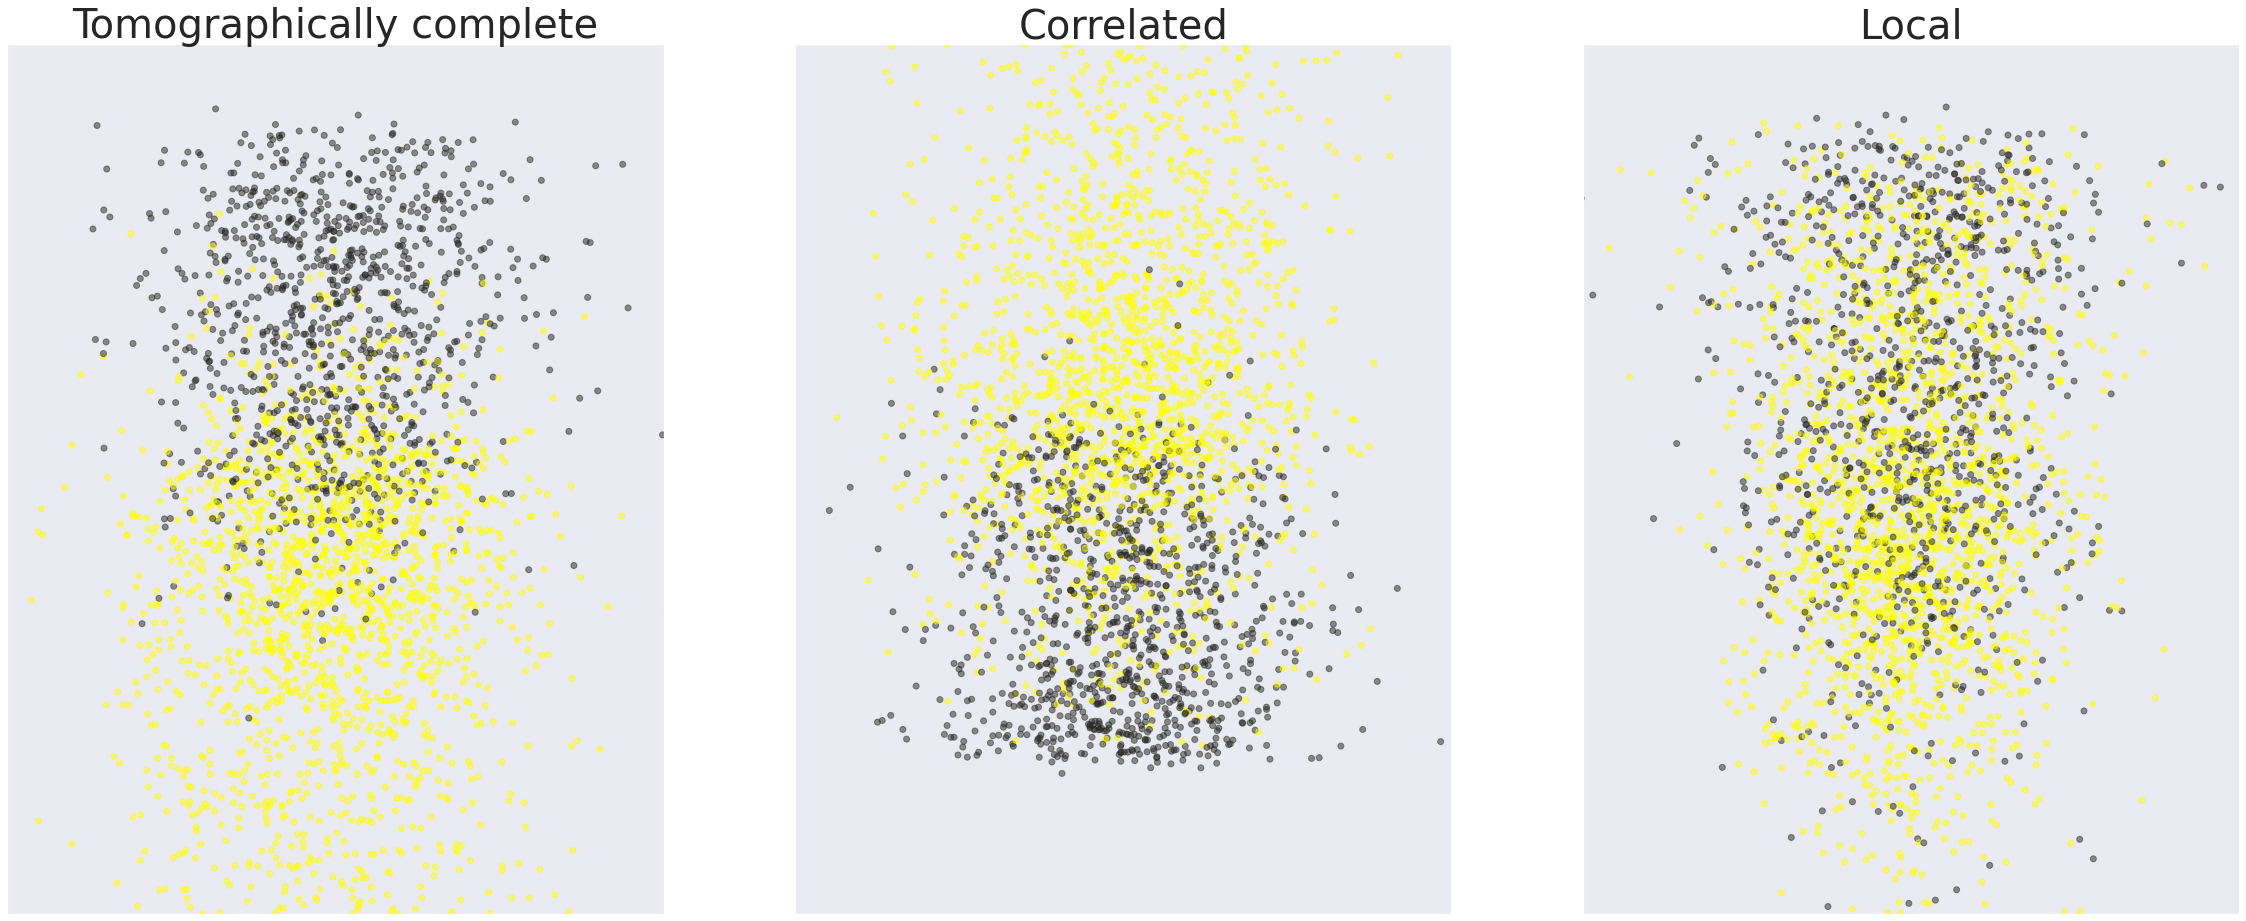

In [56]:
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,16))

lims= 3
title_size = 40
im1 = ax1.scatter(z_mu_0[:, 0], z_mu_0[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax1.set_title(f'Tomographically complete', size=title_size)
ax1.grid()
ax1.set_ylim(-lims,lims)
ax1.set_xlim(-lims,lims)
for xlabel_i in ax1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)

for xlabel_i in ax1.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
#plt.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z_mu_1[:, 1], z_mu_1[:, 0], cmap=pal, alpha=0.5, c=Y_test)
ax2.set_title(f'Correlated', size=title_size)
ax2.grid()
ax2.set_ylim(-lims,lims)
ax2.set_xlim(-lims,lims)
for xlabel_i in ax2.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in ax2.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
#plt.colorbar(im2, ax=ax2)

im3 = ax3.scatter(z_mu_2[:, 0], z_mu_2[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Local', size=title_size)
ax3.grid()
ax3.set_ylim(-lims,lims)
ax3.set_xlim(-lims,lims)
for xlabel_i in ax3.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in ax3.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
#plt.colorbar(im3, ax=ax3)
plt.show()

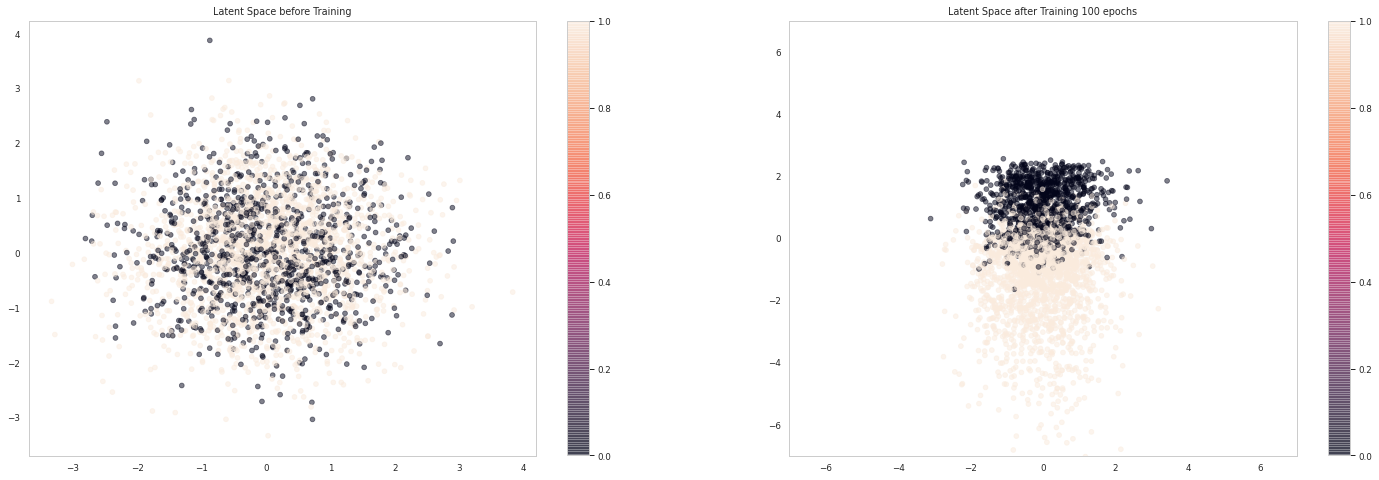

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))

lims = 7

ims = ax1.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.5, c=Y_test)
ax1.set_title(f'Latent Space before Training')
ax1.grid()
plt.colorbar(ims, ax=ax1)

ims = ax2.scatter(z_mu_0[:, 0], z_mu_0[:, 1], alpha=0.5, c=Y_test)
ax2.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax2.set_ylim(-lims,lims)
ax2.set_xlim(-lims,lims)
ax2.grid()
plt.colorbar(ims, ax=ax2)
plt.show()